Trends in Dipole Field 
=====
***

Compute the trends in the dipole field from a realization of the stochastic model. 

In [1]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles
using Interpolations
using GLM

In [2]:
# Input realization of stochastic dynamo model
#
data = readdlm("dipole_3000.txt", '\t', Float64, '\n')
td = data[:,1];
xd = data[:,2];
ndata = length(td)

200000

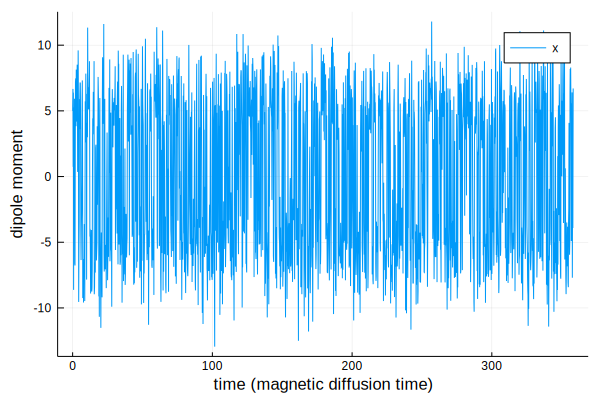

In [3]:
idecimate = 100;
plot(td[1:idecimate:end],xd[1:idecimate:end],
    xlabel="time (magnetic diffusion time)",
    ylabel="dipole moment",label="x")

358363


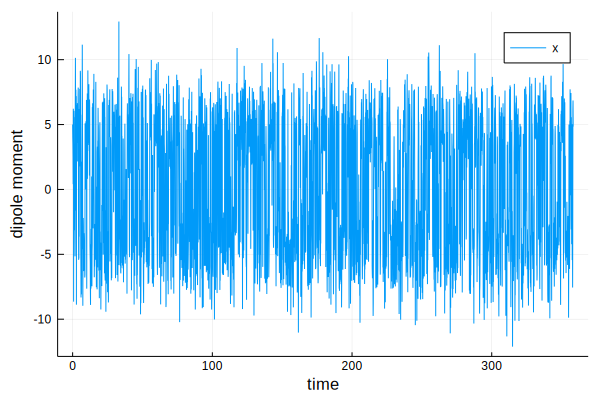

In [5]:
# Interpolate onto a uniform time grid
dt =  0.001; # 1 kyr interval
tinp = (0.0 : dt : td[end]);
nodes = (td,);
itp = interpolate(nodes,xd,Gridded(Linear()));
xinp = itp(tinp);
ndata = length(tinp)
println(ndata)
plot(tinp[1:idecimate:end],xinp[1:idecimate:end],
    xlabel="time",
    ylabel="dipole moment",
    label="x")

In [6]:
# take absolute value of realization
a = abs.(xinp);
xbar = mean(a);
xmed = median(a)
println("mean = ",xbar,"  ","median = ",xmed," skewness = ",skewness(a))

mean = 4.786959475501882  median = 4.720952738580355 skewness = 0.1642254345200471


Compute correlation coefficient of amplitude $a(t) = |x(t)|$. 

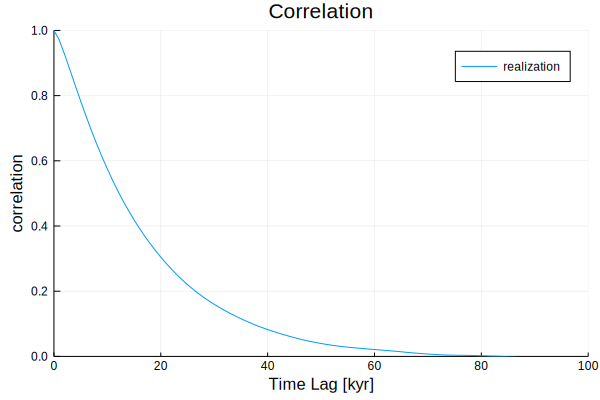

In [9]:
# compute correlation of a(t)
nlags = 100;
lag = zeros(nlags)
c = zeros(nlags)
c[1] = 1.0;
da = a .- mean(a);
for i = 2 : nlags
    lag[i] = (i-1) * dt;
    y = da[i:end];
    z = da[1:end-i+1];
    c[i] = cor(da[1:end-i+1],da[i:end]);
end
plot(lag*1000,c,title="Correlation",
    xlabel="Time Lag [kyr]",
    ylabel="correlation",
    label="realization",
    xlim=(0,100),
    ylim=(0,1.0))


Compute least-squares fit using GLM package

In [10]:
function slopes(nintvl,t,x)
    nsamples = Int(floor(length(x)/nintvl));
    b = zeros(nsamples)
    X = ones(nintvl,2)
    X[:,2] = t[1:nintvl] .- t[1];
    
    for i = 1 : nsamples
        istart = 1 + (i-1) * nintvl;
        ols = lm(X,x[istart:istart+nintvl-1]);
        b[i] = coef(ols)[2];
    end
    
return b
end


slopes (generic function with 1 method)

Compute skewness for time intervals between 2kyr to 50 kyr (every 2 kyr)

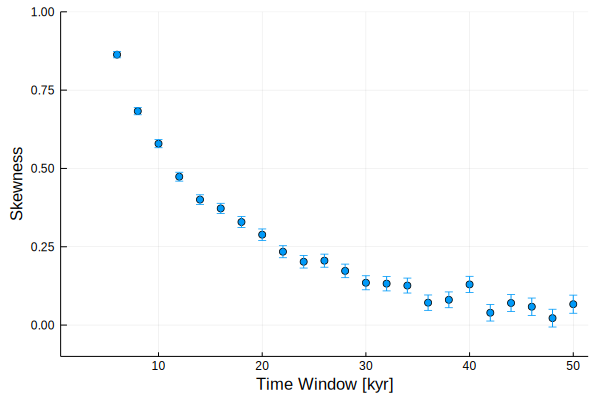

In [14]:
sk = zeros(25);
err = zeros(25);
window = zeros(25);
kyr = 1000.0;    # conversion from million years

for i = 1 : 25
    b = slopes(i * 2,tinp,a);
    sk[i] = skewness(b);
    err[i] = sqrt(6.0/length(b));
    window[i] = i * 2.0 * dt;
end

plot(window*kyr,sk,yerror=err,
    xlabel="Time Window [kyr]", 
    ylabel="Skewness",
    st=:scatter,
    ylim=(-0.1,1.0),
    legend=nothing)

In [26]:
savefig("skewness.pdf"